# Import Libraries

In [ ]:
# Scraper
from google_play_scraper import app
from google_play_scraper import Sort, reviews_all

# Dataframes
import pandas as pd
import numpy as np

# Text Processing
import regex as re
%pylab inline
from collections import Counter
from nltk.corpus import stopwords
import nltk
from nltk import ngrams
from nltk.tokenize.toktok import ToktokTokenizer
import collections
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer  
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

import seaborn as sns 
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud
%matplotlib inline
nltk.download('wordnet')

# Scrape Reviews from Google Play Store

In [ ]:
#US Market
us_reviews = reviews_all(
    'com.coinbase.android',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

df_coinbase = pd.DataFrame(np.array(us_reviews),columns=['review'])


df_coinbase = df_coinbase.join(pd.DataFrame(df_coinbase.pop('review').tolist()))


df_coinbase.head(1)

# EDA

In [276]:
df = pd.read_csv("reviews_cb.csv")
df.head(1)

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,0,gp:AOqpTOGVaBRFk70o8DKCdhFzZi0JCPLEPDDDJ3CKuck...,Freddie Marez,https://play-lh.googleusercontent.com/a/AATXAJ...,Cant access my assets on the app keeps saying ...,1,0,10.10.13,2022-03-24 19:23:48,NaN,NaN


In [277]:
df['at']= pd.to_datetime(df['at'])
df = df.rename(columns={'at': 'Date'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129681 entries, 0 to 129680
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            129681 non-null  int64         
 1   reviewId              129681 non-null  object        
 2   userName              129680 non-null  object        
 3   userImage             129681 non-null  object        
 4   content               129648 non-null  object        
 5   score                 129681 non-null  int64         
 6   thumbsUpCount         129681 non-null  int64         
 7   reviewCreatedVersion  112771 non-null  object        
 8   Date                  129681 non-null  datetime64[ns]
 9   replyContent          22466 non-null   object        
 10  repliedAt             22466 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 10.9+ MB


Text(0, 0.5, '# of Reviews')

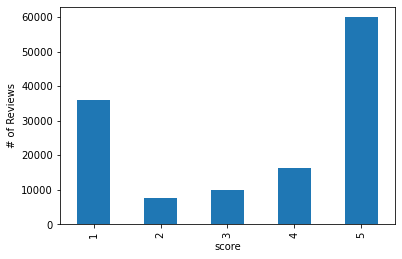

In [290]:
df.groupby(["score"]).score.count().plot.bar()
plt.ylabel("# of Reviews")

# Pre-Processing Text

In [278]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lemmatize_text(text):
    return [WordNetLemmatizer().lemmatize(w) for w in w_tokenizer.tokenize(text)]

def join_list(text):
    return ' '.join(text)

In [279]:
df.dropna(subset = ['content','score'], inplace=True)
df['content'] = df['content'].str.lower()
df['content'] = df['content'].str.strip()
#replace punctuations with space
df['content'] = df['content'].str.replace(r'[^\w\s]',"")
#Create column without stopwords
stop = stopwords.words('english')
df["cleaned_content"] = df['content'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
#Lemmatize text and rejoin to a string
df["cleaned_content"] = df["cleaned_content"].apply(lemmatize_text)
df["cleaned_content"] = df["cleaned_content"].apply(lambda x: ' '.join(x))
df.reset_index(inplace=True)

C:\Users\Mario\AppData\Local\Temp/ipykernel_24552/3653159494.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['content'] = df['content'].str.replace(r'[^\w\s]',"")


In [280]:
#Function to count a mention at most once a post
def check_for_bigram(post):
    count = 0
    # get bigrams of post
    words = post.split()
    
    # Check if 
    for word in words:
        if count == 0:
            if word == 'support' or word == 'service':
                count = 1
    return count

In [287]:
# Divide positive and negative reviews
neg_reviews = df[df.score <= 3]
neg_reviews2 = neg_reviews.copy()
neg_reviews2.reset_index(inplace=True)

pos_reviews = df[df.score >= 4]
pos_reviews2 = pos_reviews.copy()
pos_reviews2.reset_index(inplace=True)

neg_reviews2['About_Customer_Service'] = neg_reviews2.iloc[:,13].apply(check_for_bigram)

print("# of Negative Reviews about Customer Support:" ,len(neg_reviews2[neg_reviews2.About_Customer_Service == 1]))
neg_reviews2.head(1)

# of Negative Reviews about Customer Support: 7734


,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,Date,replyContent,repliedAt,cleaned_content,About_Customer_Service
0,0,0,0,gp:AOqpTOGVaBRFk70o8DKCdhFzZi0JCPLEPDDDJ3CKuck...,Freddie Marez,https://play-lh.googleusercontent.com/a/AATXAJ...,cant access my assets on the app keeps saying ...,1,0,10.10.13,2022-03-24 19:23:48,NaN,NaN,cant access asset app keep saying unable conne...,0


# Reviews About Customer Service

# of Negative reviews about Customer Service:
Q3:  1261
Q4:  1393
Jan:  208
Feb:  228

Monthly Change: 9.6%
Quarterly Change: 9.5%


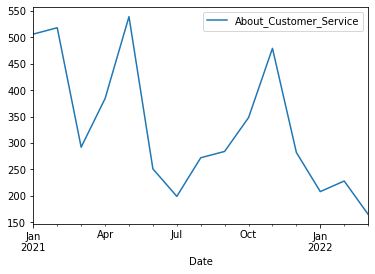

In [286]:
revs_2020 = neg_reviews2.loc[(neg_reviews2['Date'] > '2021-1-1')]
mth_reviews = revs_2020.groupby(pd.Grouper(key='Date',freq='M')).sum()

feb_reviews = mth_reviews.About_Customer_Service[-2]
jan_reviews = mth_reviews.About_Customer_Service[-3]
mth_change = (feb_reviews - jan_reviews)/jan_reviews*100

reviews_Q4_21 = mth_reviews.About_Customer_Service[-7:-3].sum()
reviews_Q3_21 = mth_reviews.About_Customer_Service[-11:-7].sum()
qtr_change = (reviews_Q4_21 - reviews_Q3_21)/reviews_Q4_21*100
print("# of Negative reviews about Customer Service:")
print("Q3: ",reviews_Q3_21)
print("Q4: ", reviews_Q4_21)
print("Jan: ", jan_reviews)
print("Feb: ", feb_reviews)
print("")      
print("Monthly Change: {:.1f}%".format(mth_change))
print("Quarterly Change: {:.1f}%".format(qtr_change))

mth_reviews.plot(y = 'About_Customer_Service', use_index = True);

# WordCloud

In [ ]:
neg_rev_list = neg_reviews2.split()
neg_trigrams = frequent_words(neg_rev_list, ngrams_number = 3, number_top_words = 20)
neg_bigrams = frequent_words(neg_rev_list, ngrams_number = 2, number_top_words = 20)
neg_words = frequent_words(neg_rev_list, ngrams_number = 1, number_top_words = 10)
print("Top Trigrams")
print(neg_trigrams[:20])
print("Top Bigrams")
print(neg_bigrams[:20])
print("Top Words")
print(neg_words)

In [4]:
# Split positive and Negative Reviews
pos_rev=" "
neg_rev=" "

for i in range(len(df)):
    if df["score"][i]>=4:
        pos_rev=pos_rev+" "+df["content_no_stopwords"][i]
    if df["score"][i]<=3:
        neg_rev=neg_rev+" "+df["content_no_stopwords"][i]  

# Create Tokenizer
tokenizer = nltk.tokenize.RegexpTokenizer('\w+')

#Tokenize positive and negative reviews
pos_tokens = tokenizer.tokenize(pos_rev)
neg_tokens = tokenizer.tokenize(neg_rev)

# Lemmatize Text
wn = WordNetLemmatizer() 

lem_words_pos=[]
lem_words_neg=[]

for word in pos_tokens:
    word=wn.lemmatize(word)
    lem_words_pos.append(word)

for word in neg_tokens:
    word=wn.lemmatize(word)
    lem_words_neg.append(word)

res_pos=' '.join([i for i in lem_words_pos if not i.isdigit()])
res_neg=' '.join([i for i in lem_words_neg if not i.isdigit()])

In [35]:
plt.rcParams["figure.figsize"] = [16, 9]

def create_ngrams(token_list, nb_elements):

    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)

def frequent_words(list_words, ngrams_number=1, number_top_words=10):

    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError("number of n-grams should be >= 1")
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


def make_word_cloud(text_or_counter, stop_words=None):
    if isinstance(text_or_counter, str):
        word_cloud = WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
        word_cloud = WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

## Negative Reviews

In [45]:
neg_rev_list = res_neg.split()
neg_trigrams = frequent_words(neg_rev_list, ngrams_number = 3, number_top_words = 20)
neg_bigrams = frequent_words(neg_rev_list, ngrams_number = 2, number_top_words = 20)
neg_words = frequent_words(neg_rev_list, ngrams_number = 1, number_top_words = 10)
print("Top Trigrams")
print(neg_trigrams[:20])
print("Top Bigrams")
print(neg_bigrams[:20])
print("Top Words")
print(neg_words)

Top Trigrams
[('add payment method', 444), ('something went wrong', 441), ('dont waste time', 208), ('get money back', 203), ('oops something went', 203), ('cant even get', 177), ('worst app ever', 170), ('terrible customer service', 168), ('worst customer service', 151), ('link bank account', 151), ('cant buy sell', 146), ('dont use app', 138), ('app doesnt work', 137), ('fee way high', 137), ('app wont let', 125), ('cant add payment', 124), ('every time try', 123), ('cant even sign', 106), ('horrible customer service', 103), ('money bank account', 102)]
Top Bigrams
[('customer service', 2899), ('bank account', 1599), ('cant even', 1217), ('wont let', 1211), ('customer support', 1188), ('buy sell', 1126), ('payment method', 919), ('use app', 905), ('doesnt work', 831), ('high fee', 829), ('every time', 752), ('cant get', 748), ('waste time', 693), ('fee high', 650), ('easy use', 650), ('good app', 591), ('phone number', 589), ('debit card', 581), ('cant buy', 571), ('please fix', 547)

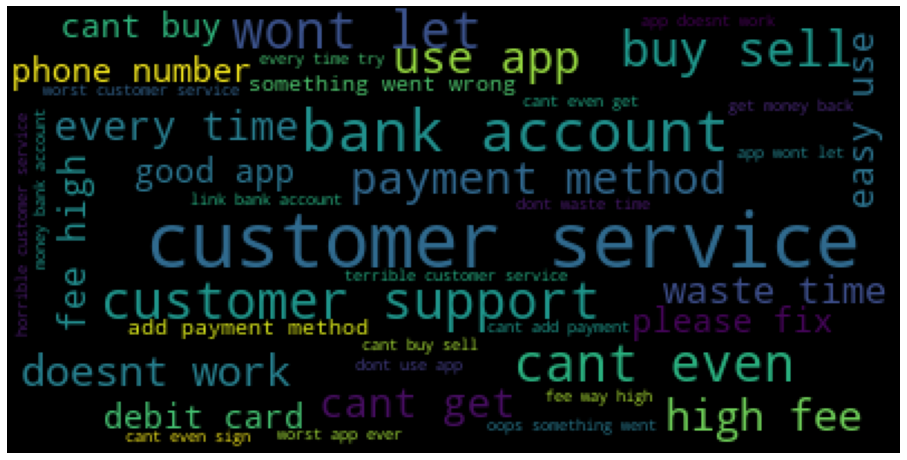

In [42]:
ngrams = neg_bigrams + neg_trigrams
neg_counter = Counter(dict(ngrams))
make_word_cloud(neg_counter, stop_words=None)

## Positve Reviews

In [43]:
pos_rev_list = res_pos.split()
pos_trigrams = frequent_words(pos_rev_list, ngrams_number = 3, number_top_words = 20)
pos_bigrams = frequent_words(pos_rev_list, ngrams_number = 2, number_top_words = 20)
pos_words = frequent_words(pos_rev_list, ngrams_number = 1, number_top_words = 10)
print("Top Trigrams")
print(pos_trigrams[:10])
print("Top Bigrams")
print(pos_bigrams[:10])
print("Top Words")
print(pos_words)

Top Trigrams
[('app easy use', 1189), ('easy use great', 596), ('great app easy', 547), ('easy use good', 442), ('easy use easy', 419), ('app great app', 416), ('app good app', 337), ('great easy use', 321), ('good easy use', 300), ('easy use love', 272)]
Top Bigrams
[('easy use', 7935), ('great app', 4413), ('good app', 3099), ('nice app', 2059), ('app easy', 1687), ('app good', 1255), ('app great', 1244), ('user friendly', 1231), ('buy sell', 1117), ('love app', 1067)]
Top Words
[('app', 22170), ('easy', 14030), ('good', 12129), ('great', 11735), ('use', 11132), ('nice', 6680), ('crypto', 6648), ('love', 5243), ('coinbase', 4984), ('like', 3744)]


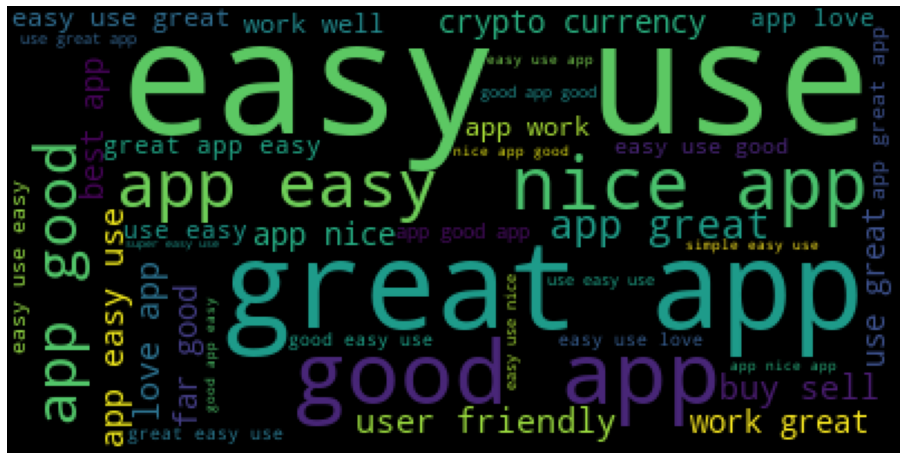

In [44]:
ngrams = pos_bigrams + pos_trigrams
pos_counter = Counter(dict(ngrams))
make_word_cloud(pos_counter, stop_words=None)